# Введение в искусственные нейронные сети
# Урок 6. Сегментация
## Практическое задание   


Вариант 1
<ol>
<li>Попробуйте обучить нейронную сеть U-Net на любом другом датасете.  
<li>Опишите, какой результата вы получили? Что помогло вам улучшить качество сети?  
</ol>

Вариант 2  
*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview<br>   
Вариант 3   
*Сделайте свою реализацию U-Net на TensorFlow  

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [41]:
import numpy as np
import pandas as pd

import os
import random
import cv2

from PIL import Image
from sklearn.cluster import KMeans

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Tensorflow with TPU

In [4]:
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print('All devices: ', tf.config.list_logical_devices('TPU'))

### Tensorflow with GPU

In [5]:
# %tensorflow_version 2.x
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#     raise SystemError('GPU device not found')

# def cpu():
#     with tf.device('/cpu:0'):
#         random_image_cpu = tf.random.normal((100, 100, 100, 3))
#         net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#         return tf.math.reduce_sum(net_cpu)

# def gpu():
#     with tf.device('/device:GPU:0'):
#         random_image_gpu = tf.random.normal((100, 100, 100, 3))
#         net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#         return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup='from __main__ import cpu')
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup='from __main__ import gpu')
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

## Panoptic Segmentation

https://www.cityscapes-dataset.com/panoptic-segmentation/

<img style='float: right;' src='11.jpg'>

The Cityscapes benchmark suite now includes panoptic segmentation [1], which combines pixel- and instance-level semantic segmentation. Our toolbox offers ground truth conversion and evaluation scripts. Our evaluation server and benchmark tables have been updated to support the new panoptic challenge.

We thank Alexander Kirillov for helping with the implementation.

[1] A. Kirillov, K. He, R. Girshick, C. Rother, and P. Dollár, “Panoptic segmentation,” in CVPR, 2019.

### Загрузка данных

In [44]:
def LoadImage(name, path='./cityscapes_data/train',
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+'/'+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

In [45]:
files =os.listdir('./cityscapes_data/train')[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(n_clusters=13)

In [46]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

### Построение модели

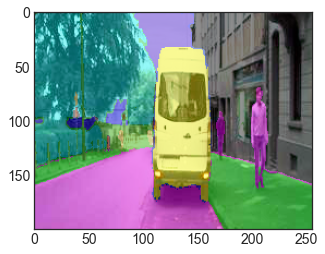

In [48]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage('174.jpg')
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plt.imshow(total[:,:,:])
plt.show()

### Data Generator

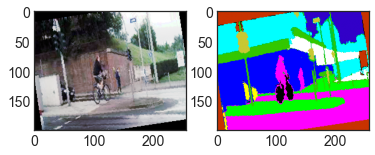

In [50]:
def Generate(path='./cityscapes_data/train', batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plt.subplot(121)
plt.imshow(imgs[0])
plt.subplot(122)
plt.imshow(LayersToRGBImage(segs[0]))
plt.show()

### Model / The Convolutional Neural Network - UNet

In [51]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation='relu', padding='same')(x1)
x1 = Conv2D(128, 12, activation='relu', padding='same')(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation='relu', padding='same')(p1)
x2 = Conv2D(128, 9, activation='relu', padding='same')(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation='relu', padding='same')(p2)
x3 = Conv2D(128, 6, activation='relu', padding='same')(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
x4 = Conv2D(128, 3, activation='relu', padding='same')(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation='relu', padding='same')(x5)
x5 = Conv2D(128, 6, activation='relu', padding='same')(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation='relu', padding='same')(x6)
x6 = Conv2D(128, 6, activation='relu', padding='same')(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation='relu', padding='same')(x7)
x7 = Conv2D(13, 6, activation='softmax', padding='same')(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 256, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 256, 128 1179776     conv2d[0][0]                     
_______________________________________________________________________________________

In [52]:
train_gen = Generate()
val_gen = Generate('./cityscapes_data/val')

In [53]:
clb = [ModelCheckpoint('loss.h5', save_best_only=True, verbose=0)]

h = model.fit_generator(train_gen, epochs=1000, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=0)

Instructions for updating:
Please use Model.fit, which supports generators.


KeyboardInterrupt: 

In [ ]:
model.save('model.h5')
model = load_model('loss.h5')

In [ ]:
loss = h.history['val_loss']
acc = h.history['val_acc']

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title('Val. Loss')
plot.plot(loss)
plot.xlabel('Epoch')
plot.ylabel('Loss')

plot.subplot(212)
plot.title('Val. Accuracy')
plot.plot(acc)
plot.xlabel('Epoch')
plot.ylabel('Accuracy')

plot.tight_layout()
plot.savefig('learn.png', dpi=150)
plot.show()

### Results

In [ ]:
test_gen = Generate('./cityscapes_data/val')
max_show=20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title('Prediction')
        plot.imshow(predimg)
        plot.axis('off')
        plot.subplot(122)
        plot.title('True')
        plot.imshow(trueimg)
        plot.axis('off')
        plot.tight_layout()
        plot.savefig('pred_'+str(i)+'.png', dpi=150)
        plot.show()
    break

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = Generate('./cityscapes_data/val', batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title('Class '+str(i))
        plot.xlabel('False positive rate')
        plot.ylabel('True positive rate')
    
    plot.tight_layout()
    plot.show()
    
    break

In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel('Balanced Accuracy')
plot.xlabel('Class')
plot.tight_layout()
plot.savefig('bas.png')
plot.show()